# Barplot of Samples by Country

## Introduction

This notebook recreates [Supplement Figure 1 from the Pf7 paper](https://figshare.com/ndownloader/files/38478530) - a bar plot which shows the number of samples in the Pf7 release, broken down by country. Each bar also details the number of samples passing QC (or not) per country.

**This notebook should take approximately 1 minute to run.**

## Setup

Install and import the malariagen Python package:

In [ ]:
!pip install -q --no-warn-conflicts malariagen_data
import malariagen_data

Import required python libraries that are installed at colab by default.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import collections
from google.colab import drive

## Access Pf7 Data

We use the malariagen data package to load the release data.

In [ ]:
release_data = malariagen_data.Pf7()
sample_metadata = release_data.sample_metadata()

In [ ]:
sample_metadata.head(3)

,Sample,Study,Country,Admin level 1,Country latitude,Country longitude,Admin level 1 latitude,Admin level 1 longitude,Year,ENA,All samples same case,Population,% callable,QC pass,Exclusion reason,Sample type,Sample was in Pf6
0,FP0008-C,1147-PF-MR-CONWAY,Mauritania,Hodh el Gharbi,20.265149,-10.337093,16.565426,-9.832345,2014.0,ERR1081237,FP0008-C,AF-W,82.16,True,Analysis_set,gDNA,True
1,FP0009-C,1147-PF-MR-CONWAY,Mauritania,Hodh el Gharbi,20.265149,-10.337093,16.565426,-9.832345,2014.0,ERR1081238,FP0009-C,AF-W,88.85,True,Analysis_set,gDNA,True
2,FP0010-CW,1147-PF-MR-CONWAY,Mauritania,Hodh el Gharbi,20.265149,-10.337093,16.565426,-9.832345,2014.0,ERR2889621,FP0010-CW,AF-W,86.46,True,Analysis_set,sWGA,False


We can start exploring the data by answering these questions:


*   How many samples with QC pass
*   How many samples in each country



In [ ]:
# Calculate the total number of samples
total_sample_number = sample_metadata.Sample.count()

# Calculate the number of samples that passed QC
qc_pass_count = (sample_metadata['QC pass'] == True).sum()

# Calculate the number of samples that failed QC
qc_fail_count = (sample_metadata['QC pass'] == False).sum()

print(f"We see {total_sample_number} samples of which {qc_pass_count} QC-pass and {qc_fail_count} QC fail in the overall Pf7 dataset.")

We see 20864 samples of which 16203 QC-pass and 4661 QC fail in the overall Pf7 dataset.


In [ ]:
# Calculate the number of samples in each country
sample_metadata['Country'].value_counts()

Ghana                               4090
Mali                                1804
Vietnam                             1733
Cambodia                            1723
Bangladesh                          1658
Myanmar                             1260
Gambia                              1247
Thailand                            1106
Laos                                1052
Kenya                                726
Tanzania                             697
Democratic Republic of the Congo     573
Malawi                               371
Benin                                334
India                                316
Cameroon                             294
Papua New Guinea                     251
Sudan                                203
Guinea                               199
Colombia                             159
Senegal                              155
Nigeria                              140
Indonesia                            133
Mauritania                           104
Mozambique      

## Figure preparation: Defining populations

Countries are grouped into ten major sub-populations based on their geographic and genetic characteristics.

The dataframe has a `Population` column that contains abbreviated names, for clarity, we want to display the full name in the figure.

In [ ]:
# Define populations in an ordered dictionary
populations = collections.OrderedDict()
populations['SA'] = 'South America'
populations['AF-W'] = 'West Africa'
populations['AF-C'] = 'Central Africa'
populations['AF-NE'] = 'Northeast Africa'
populations['AF-E'] = 'East Africa'
populations['AS-S-E'] = 'Eastern South Asia'
populations['AS-S-FE'] = 'Far-eastern South Asia'
populations['AS-SE-W'] = 'Western Southeast Asia'
populations['AS-SE-E'] = 'Eastern Southeast Asia'
populations['OC-NG'] = 'Oceania'

# Map continent names into the df by using Population column and populations dictionary
sample_metadata['Continent'] = sample_metadata['Population'].map(populations)
sample_metadata.head(3)

,Sample,Study,Country,Admin level 1,Country latitude,Country longitude,Admin level 1 latitude,Admin level 1 longitude,Year,ENA,All samples same case,Population,% callable,QC pass,Exclusion reason,Sample type,Sample was in Pf6,Continent
0,FP0008-C,1147-PF-MR-CONWAY,Mauritania,Hodh el Gharbi,20.265149,-10.337093,16.565426,-9.832345,2014.0,ERR1081237,FP0008-C,AF-W,82.16,True,Analysis_set,gDNA,True,West Africa
1,FP0009-C,1147-PF-MR-CONWAY,Mauritania,Hodh el Gharbi,20.265149,-10.337093,16.565426,-9.832345,2014.0,ERR1081238,FP0009-C,AF-W,88.85,True,Analysis_set,gDNA,True,West Africa
2,FP0010-CW,1147-PF-MR-CONWAY,Mauritania,Hodh el Gharbi,20.265149,-10.337093,16.565426,-9.832345,2014.0,ERR2889621,FP0010-CW,AF-W,86.46,True,Analysis_set,sWGA,False,West Africa


In [ ]:
# Create an ordered dictionary which maps the codes for major sub-populations -from west to east- to a colour code.
population_colours = collections.OrderedDict()
population_colours['SA']       = "#4daf4a"
population_colours['AF-W']     = "#e31a1c"
population_colours['AF-C']     = "#fd8d3c"
population_colours['AF-NE']    = "#bb8129"
population_colours['AF-E']     = "#fecc5c"
population_colours['AS-S-E']  = "#dfc0eb"
population_colours['AS-S-FE']  = "#984ea3"
population_colours['AS-SE-W'] = "#9ecae1"
population_colours['AS-SE-E'] = "#3182bd"
population_colours['OC-NG']    = "#f781bf"

# Map population colours into the df by using Population column and population_colours dictionary
sample_metadata['population_colour'] = sample_metadata['Population'].map(population_colours)

## Figure preparation: Sort countries in geographic order

We want to sort the countries on the x-axis in geographic order, which means arranging them from left to right on the chart based on their geographical location, from west to east or by continents.



### Using longitudes to locate country

To do this arrangement, we will use longitude coordinate countries which can be found in the dataset column `Country longitude`.

In [ ]:
# Find the average of longitude of samples in each country
mean_population_longitude = sample_metadata.groupby('Population')['Country longitude'].mean()

# Add a new column that conveys mean population values for each sample
sample_metadata['Population_long'] = sample_metadata['Population'].map(mean_population_longitude)

## Splitting countries with multi-populations

We identified three countries (Kenya, India, and Thailand) where the sampling locations are associated with more than one major sub-population". For example, Kenya has sampling locations from AF-NE and AF-E, and this causes problems with ordering on country longitude because AF-NE and AF-E become mixed up in the table.

To accurately represent this diversity, we created a new column called `Country_or_admin1` and `Country_or_admin1_long` in our sample metadata.

These columns categorizes these countries based on their first-level administrative divisions.

In [ ]:
# Create a duplicate column with country names
sample_metadata['Country_or_admin1'] = sample_metadata['Country']
sample_metadata['Country_or_admin1_long'] = sample_metadata['Country longitude']

# Rename each 'Admin level 1' of split-countries
sample_metadata.loc[(sample_metadata['Country'] == 'Kenya') & (sample_metadata['Admin level 1'] == 'Kilifi'), 'Country_or_admin1'] = 'Kenya, Kilifi'
sample_metadata.loc[(sample_metadata['Country'] == 'Kenya') & (sample_metadata['Admin level 1'] == 'Kisumu'), 'Country_or_admin1'] = 'Kenya, Kisumu'
sample_metadata.loc[(sample_metadata['Country'] == 'India') & (sample_metadata['Admin level 1'] == 'Tripura'), 'Country_or_admin1'] = 'India, Tripura'
sample_metadata.loc[(sample_metadata['Country'] == 'India') & (sample_metadata['Admin level 1'] == 'Odisha'), 'Country_or_admin1'] = 'India, Odisha or West Bengal'
sample_metadata.loc[(sample_metadata['Country'] == 'India') & (sample_metadata['Admin level 1'] == 'West Bengal'), 'Country_or_admin1'] = 'India, Odisha or West Bengal'
sample_metadata.loc[(sample_metadata['Country'] == 'Thailand') & (sample_metadata['Admin level 1'] == 'Sisakhet'), 'Country_or_admin1'] = 'Thailand, Sisakhet'
sample_metadata.loc[(sample_metadata['Country'] == 'Thailand') & (sample_metadata['Admin level 1'] == 'Tak'), 'Country_or_admin1'] = 'Thailand, Tak or Ranong'
sample_metadata.loc[(sample_metadata['Country'] == 'Thailand') & (sample_metadata['Admin level 1'] == 'Ranong'), 'Country_or_admin1'] = 'Thailand, Tak or Ranong'

# Set longitude to that of admin1 for split countries
sample_metadata.loc[
    sample_metadata['Country_or_admin1'] != sample_metadata['Country'],
    'Country_or_admin1_long'
] = sample_metadata.loc[
    sample_metadata['Country_or_admin1'] != sample_metadata['Country'],
    'Admin level 1 longitude'
]

# Set longitude to that of admin1 with most samples for countries with more than one admin1 in population
sample_metadata.loc[
    sample_metadata['Country_or_admin1'] == 'India, Odisha or West Bengal',
    'Country_or_admin1_long'
] = sample_metadata.loc[
    ( sample_metadata['Country'] == 'India' )
     & ( sample_metadata['Admin level 1'] == 'Odisha' ),
    'Country_or_admin1_long'
].values[0]
sample_metadata.loc[
    sample_metadata['Country_or_admin1'] == 'Thailand, Tak or Ranong',
    'Country_or_admin1_long'
] = sample_metadata.loc[
    ( sample_metadata['Country'] == 'Thailand' )
     & ( sample_metadata['Admin level 1'] == 'Tak' ),
    'Country_or_admin1_long'
].values[0]

Next, we want to arrange the divisions from the same countries adjacent to each other in order to facilitate meaningful comparisons when we look at the figure.

In order to do that we simply adjust their longitude values.

In [ ]:
# Adjust the longitude values to appear first or last
sample_metadata.loc[sample_metadata['Country_or_admin1'] == 'Kenya, Kisumu', 'Country_or_admin1_long'] = 40 # Want it to appear last in AF-NE
sample_metadata.loc[sample_metadata['Country_or_admin1'] == 'Kenya, Kilifi', 'Country_or_admin1_long'] = 34 # Want it to appear first in AF-E
sample_metadata.loc[sample_metadata['Country_or_admin1'] == 'India, Tripura', 'Country_or_admin1_long'] = 90 # Want it to appear first in AS-S-FE
sample_metadata.loc[sample_metadata['Country_or_admin1'] == 'Thailand, Sisakhet', 'Country_or_admin1_long'] = 103 # Want it to appear first in AS-SE-E

Finally, we don't want Kenya returning travellers shown on plot, as we don't know which admin division(s) they could have visited.

In [ ]:
sample_metadata.loc[sample_metadata['Country_or_admin1'] == 'Kenya', 'Population'] = None

### Sorting countries

Now the countries are ready to sort geographically.

In [ ]:
df_country_or_admin1 = (
    pd.DataFrame(
        sample_metadata
        .groupby(['Continent', 'Population', 'population_colour',
                  'Country_or_admin1', 'Population_long',
                  'Country_or_admin1_long'])
        .size()
    )
    .reset_index()
    .set_index('Country_or_admin1')
    .sort_values(['Population_long', 'Country_or_admin1_long'])
    .rename(columns={0: 'Frequency (number of samples)'})
)

print(df_country_or_admin1.shape)
df_country_or_admin1

(36, 6)


,Continent,Population,population_colour,Population_long,Country_or_admin1_long,Frequency (number of samples)
Country_or_admin1,,,,,,
Peru,South America,SA,#4daf4a,-73.157010,-74.356842,21
Colombia,South America,SA,#4daf4a,-73.157010,-73.086731,159
Venezuela,South America,SA,#4daf4a,-73.157010,-66.145936,2
Gambia,West Africa,AF-W,#e31a1c,-3.519507,-15.372910,1247
Senegal,West Africa,AF-W,#e31a1c,-3.519507,-14.470363,155
Guinea,West Africa,AF-W,#e31a1c,-3.519507,-10.936960,199
Mauritania,West Africa,AF-W,#e31a1c,-3.519507,-10.337093,104
Côte d'Ivoire,West Africa,AF-W,#e31a1c,-3.519507,-5.554446,71
Mali,West Africa,AF-W,#e31a1c,-3.519507,-3.522152,1804


We want to seperate and sort QC pass samples which will help to distinguish QC-fail samples in the figure.

In [ ]:
df_country_or_admin1_pass = (
    pd.DataFrame(
        sample_metadata
        .loc[sample_metadata['QC pass']]
        .groupby(['Continent', 'Population',
                  'population_colour', 'Country_or_admin1',
                  'Population_long', 'Country_or_admin1_long'])
        .size()
    )
    .reset_index()
    .set_index('Country_or_admin1')
    .sort_values(['Population_long', 'Country_or_admin1_long'])
    .rename(columns={0: 'Frequency (number of samples)'})
)
print(df_country_or_admin1_pass.shape)
df_country_or_admin1_pass

(36, 6)


,Continent,Population,population_colour,Population_long,Country_or_admin1_long,Frequency (number of samples)
Country_or_admin1,,,,,,
Peru,South America,SA,#4daf4a,-73.157010,-74.356842,21
Colombia,South America,SA,#4daf4a,-73.157010,-73.086731,135
Venezuela,South America,SA,#4daf4a,-73.157010,-66.145936,2
Gambia,West Africa,AF-W,#e31a1c,-3.519507,-15.372910,863
Senegal,West Africa,AF-W,#e31a1c,-3.519507,-14.470363,150
Guinea,West Africa,AF-W,#e31a1c,-3.519507,-10.936960,151
Mauritania,West Africa,AF-W,#e31a1c,-3.519507,-10.337093,92
Côte d'Ivoire,West Africa,AF-W,#e31a1c,-3.519507,-5.554446,71
Mali,West Africa,AF-W,#e31a1c,-3.519507,-3.522152,1167


Finally, we rename some countries with long names to shorter names to prevent the restriction of figure size.

In [ ]:
# rename the long-name countries in total samples df
df_country_or_admin1.rename(index={'Democratic Republic of the Congo': 'DRC'},inplace=True)
df_country_or_admin1.rename(index={'India, Odisha or West Bengal': 'India, Odisha\nor West Bengal'},inplace=True)
df_country_or_admin1.rename(index={'Thailand, Tak or Ranong': 'Thailand, Tak\nor Ranong'},inplace=True)

# rename the long-name countries in QC-pass samples df
df_country_or_admin1_pass.rename(index={'Democratic Republic of the Congo': 'DRC'},inplace=True)
df_country_or_admin1_pass.rename(index={'India, Odisha or West Bengal': 'India, Odisha\nor West Bengal'},inplace=True)
df_country_or_admin1_pass.rename(index={'Thailand, Tak or Ranong': 'Thailand, Tak\nor Ranong'},inplace=True)

## Make the figure

We have the following considerations when making of this figure:
1.   While QC failed samples shown as outline only, others should have a solid-background to distinguish from each other
2.   Lines and annotations at bottom for both continent and population.
3.   The y-axis is truncated at 2,000 samples for visual clarity. With over 3,000 samples, Ghana is affected by this truncation. Therefore, specific annotations for QC pass and fail are positioned above Ghana's bar to highlight its significance.

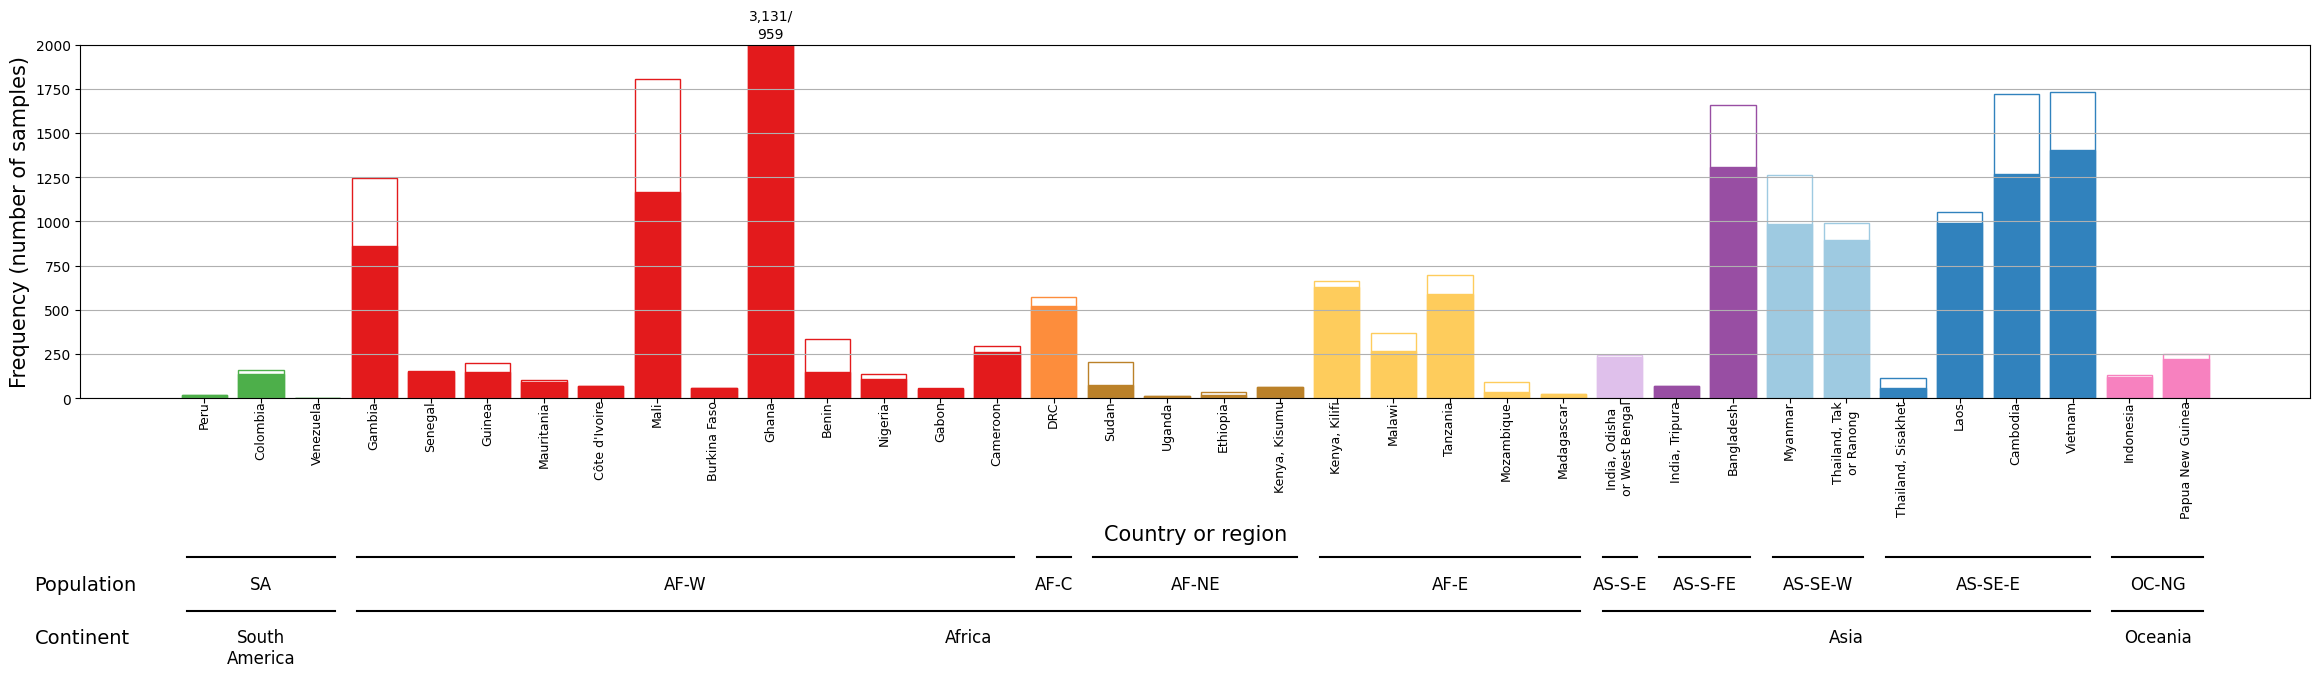

In [ ]:
# Adjust the figure size
fig, ax = plt.subplots(1, 1, figsize=(23.3, 10))

# Create the bars for all samples with a white backgound
ax.bar(
    np.arange(len(df_country_or_admin1)),
    df_country_or_admin1['Frequency (number of samples)'],
    facecolor='white',
    edgecolor = df_country_or_admin1['population_colour'],
)
# Create the bars for QC pass with solid-colour background
ax.bar(
    np.arange(len(df_country_or_admin1_pass)),
    df_country_or_admin1_pass['Frequency (number of samples)'],
    color = df_country_or_admin1['population_colour'],
    edgecolor = df_country_or_admin1['population_colour'],
)
# Set x-axis labels and rotate them for readability
ax.set_xticks(np.arange(len(df_country_or_admin1)))
ax.set_xticklabels(df_country_or_admin1.index, rotation=90)
ax.grid(True, axis='y')
# Set the y-axis limit to truncate bars at a maximum of 2000
ax.set_ylim(0, 2000)
# Set axis labels
ax.set_xlabel('Country or region',fontsize=15)
ax.set_ylabel('Frequency (number of samples)',fontsize=15)
trans = ax.get_xaxis_transform()
# Add specific annotation to Ghana
total_samples = collections.OrderedDict()
pass_samples = collections.OrderedDict()
x_pos = collections.OrderedDict()
# Set the index number for Ghana
x_pos['Ghana'] = 10
for country in x_pos:
    total_samples[country] = df_country_or_admin1.loc[country, 'Frequency (number of samples)']
    pass_samples[country] = df_country_or_admin1_pass.loc[country, 'Frequency (number of samples)']
    ax.annotate(f"{pass_samples[country]:,}/", xy=(x_pos[country], 1.1), xycoords=trans, ha="center", va="top")
    ax.annotate(f"{total_samples[country] - pass_samples[country]:,}", xy=(x_pos[country], 1.05), xycoords=trans, ha="center", va="top")
y_offset = -0.6
text_offset = 0.05
x_offset = 0.3

# Add annotations for Continents
ax.annotate('Continent', xy=(-3, y_offset-text_offset), xycoords=trans, ha="left", va="top",fontsize=14)
ax.annotate('South\nAmerica', xy=(1, y_offset-text_offset), xycoords=trans, ha="center", va="top",fontsize=12)
ax.plot([0-x_offset, 2+x_offset],[y_offset, y_offset], color="k", transform=trans, clip_on=False)
ax.annotate('Africa', xy=(13.5, y_offset-text_offset), xycoords=trans, ha="center", va="top",fontsize=12)
ax.plot([3-x_offset, 24+x_offset],[y_offset, y_offset], color="k", transform=trans, clip_on=False)
ax.annotate('Asia', xy=(29, y_offset-text_offset), xycoords=trans, ha="center", va="top",fontsize=12)
ax.plot([25-x_offset, 33+x_offset],[y_offset, y_offset], color="k", transform=trans, clip_on=False)
ax.annotate('Oceania', xy=(34.5, y_offset-text_offset), xycoords=trans, ha="center", va="top",fontsize=12)
ax.plot([34-x_offset, 35+x_offset],[y_offset, y_offset], color="k", transform=trans, clip_on=False)
y_offset = -0.45
text_offset = 0.05
x_offset = 0.3

# Add annotations for Populations
ax.annotate('Population', xy=(-3, y_offset-text_offset), xycoords=trans, ha="left", va="top",fontsize=14)
ax.annotate('SA', xy=(1, y_offset-text_offset), xycoords=trans, ha="center", va="top",fontsize=12)
ax.plot([0-x_offset, 2+x_offset],[y_offset, y_offset], color="k", transform=trans, clip_on=False)
ax.annotate('AF-W', xy=(8.5, y_offset-text_offset), xycoords=trans, ha="center", va="top",fontsize=12)
ax.plot([3-x_offset, 14+x_offset],[y_offset, y_offset], color="k", transform=trans, clip_on=False)
ax.annotate('AF-C', xy=(15, y_offset-text_offset), xycoords=trans, ha="center", va="top",fontsize=12)
ax.plot([15-x_offset, 15+x_offset],[y_offset, y_offset], color="k", transform=trans, clip_on=False)
ax.annotate('AF-NE', xy=(17.5, y_offset-text_offset), xycoords=trans, ha="center", va="top",fontsize=12)
ax.plot([16-x_offset, 19+x_offset],[y_offset, y_offset], color="k", transform=trans, clip_on=False)
ax.annotate('AF-E', xy=(22, y_offset-text_offset), xycoords=trans, ha="center", va="top",fontsize=12)
ax.plot([20-x_offset, 24+x_offset],[y_offset, y_offset], color="k", transform=trans, clip_on=False)
ax.annotate('AS-S-E', xy=(25, y_offset-text_offset), xycoords=trans, ha="center", va="top",fontsize=12)
ax.plot([25-x_offset, 25+x_offset],[y_offset, y_offset], color="k", transform=trans, clip_on=False)
ax.annotate('AS-S-FE', xy=(26.5, y_offset-text_offset), xycoords=trans, ha="center", va="top",fontsize=12)
ax.plot([26-x_offset, 27+x_offset],[y_offset, y_offset], color="k", transform=trans, clip_on=False)
ax.annotate('AS-SE-W', xy=(28.5, y_offset-text_offset), xycoords=trans, ha="center", va="top",fontsize=12)
ax.plot([28-x_offset, 29+x_offset],[y_offset, y_offset], color="k", transform=trans, clip_on=False)
ax.annotate('AS-SE-E', xy=(31.5, y_offset-text_offset), xycoords=trans, ha="center", va="top",fontsize=12)
ax.plot([30-x_offset, 33+x_offset],[y_offset, y_offset], color="k", transform=trans, clip_on=False)
ax.annotate('OC-NG', xy=(34.5, y_offset-text_offset), xycoords=trans, ha="center", va="top",fontsize=12)
_ = ax.plot([34-x_offset, 35+x_offset],[y_offset, y_offset], color="k", transform=trans, clip_on=False)

# Customize tick label fonts and spacing
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(9)
ax.tick_params(axis='x', pad=-2)

fig.tight_layout()

**Figure Legend. Breakdown of samples by country.** Solid bars indicate samples which passed QC. Unfilled bars represent samples that failed QC. The y-axis is truncated at 2,000 samples, with the numbers of QC pass/QC fail samples in Ghana shown above the bar. Bars are coloured according to the major sub-population to which the location is assigned.

### Save the figure

We can output this to a location in Google Drive

First we need to connect Google Drive by running the following:

In [ ]:
# You will need to authorise Google Colab access to Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# This will send the file to your Google Drive, where you can download it from if needed
# Change the file path if you wish to send the file to a specific location
# Change the file name if you wish to call it something else

fig.savefig('/content/drive/My Drive/SamplesByCountry_Barplot_20210720.pdf')
fig.savefig('/content/drive/My Drive/SamplesByCountry_Barplot_20210720.png', dpi=480) # increase the dpi for higher resolution